# 1. Просмотр и подготовка данных

In [172]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt

In [173]:
visits = pd.read_csv('/datasets/visits_log.csv')
orders = pd.read_csv('/datasets/orders_log.csv')
costs = pd.read_csv('/datasets/costs.csv')

In [174]:
print(visits.info())
print()
print(orders.info())
print()
print(costs.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
Device       359400 non-null object
End Ts       359400 non-null object
Source Id    359400 non-null int64
Start Ts     359400 non-null object
Uid          359400 non-null uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB
None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
Buy Ts     50415 non-null object
Revenue    50415 non-null float64
Uid        50415 non-null uint64
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB
None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null object
costs        2542 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB
None


Пропусков нет. Столбцы с данными о времени, переведем в формат date. Приведем названия столбцов к нижнему регистру.

In [175]:
visits['End Ts'] = pd.to_datetime(visits['End Ts'])
visits['Start Ts'] = pd.to_datetime(visits['Start Ts'])

orders['Buy Ts'] = pd.to_datetime(orders['Buy Ts'])

costs['dt'] = pd.to_datetime(costs['dt'])

In [176]:
visits.columns = ['device', 'end_ts', 'source_id', 'start_ts', 'uid']
orders.columns = ['buy_ts', 'revenue', 'uid']
costs.columns = ['source_id', 'dt', 'costs']

**Вывод:** Подготовили данные для дальнейшего анализа.

# 2. Отчёты и подсчет метрик

### 2.1 Подсчет количества пользователей в день / неделю / месяц

Создадим столбцы для для дальнейшей группировки пользователей по заданным временным промежуткам.

In [177]:
visits['start_ts_day'] = visits['start_ts'].astype('datetime64[D]')
visits['start_ts_month'] = visits['start_ts'].astype('datetime64[M]')
visits['start_ts_week'] = (((visits['start_ts_day'] - visits['start_ts_day'].min())
                            /np.timedelta64(1,'W'))
                           .round()
                           .astype('int'))

Сгруппируем пользователей по временным промежуткам. Подсчитаем среднее количество пользователей, с учетом используемого устройства и рекламного источникаб откуда пришел пользователь. Выведем сводную таблицу.

In [178]:
users_day = visits.groupby(['start_ts_day','device','source_id']).agg({'uid':'nunique'}).reset_index()
users_week = visits.groupby(['start_ts_week','device','source_id']).agg({'uid':'nunique'}).reset_index()
users_month = visits.groupby(['start_ts_month','device','source_id']).agg({'uid':'nunique'}).reset_index()

users_day_mean = users_day.groupby(['device','source_id'])['uid'].mean().round().astype('int')
users_week_mean = users_week.groupby(['device','source_id'])['uid'].mean().round().astype('int')
users_month_mean = users_month.groupby(['device','source_id'])['uid'].mean().round().astype('int')

users_platform = pd.DataFrame({'per_day' : users_day_mean, 'per_week' : users_week_mean, 'per_mounth' : users_month_mean})
users_platform

per_day  per_week  per_mounth
device  source_id                               
desktop 1               60       335        1284
        2               90       522        1965
        3              179      1203        5188
        4              183      1218        5162
        5              131       867        3712
        6                1         1           1
        7                1         1           2
        9               28       183         755
        10              19       120         507
touch   1               21       131         548
        2               31       199         821
        3               54       368        1609
        4               93       618        2652
        5               45       303        1320
        6                1         1           1
        7                1         1           1
        9                9        57         239
        10               7        47         204

**ВЫВОД:** Через рекламный источник 3 и 4 приходят больше всего пользователей использующих ПК (desktop). 
Через рекламный источник 4 приходят больше всего пользователей использующих мобильные устройства (touch). Данные по остальным источникам смотри в таблице.

### 2.2 Подсчет количества сессий в день

Разобьем временной промежуток на дни. Сгруппируем данные о количестве сессий по дням, с учетом применяемых устройств пользователями. Построим график.

In [179]:
visits['day_id']= visits['start_ts_day'] - visits['start_ts_day'].min()

In [180]:
session_per_day =  visits.groupby(['day_id', 'device'])['uid'].count().reset_index()
session_per_day ['day_id'] = (session_per_day ['day_id'].astype(int)/86400000000000).astype(int)
session_per_day.columns = ['день', 'устройство', 'количество сессий']

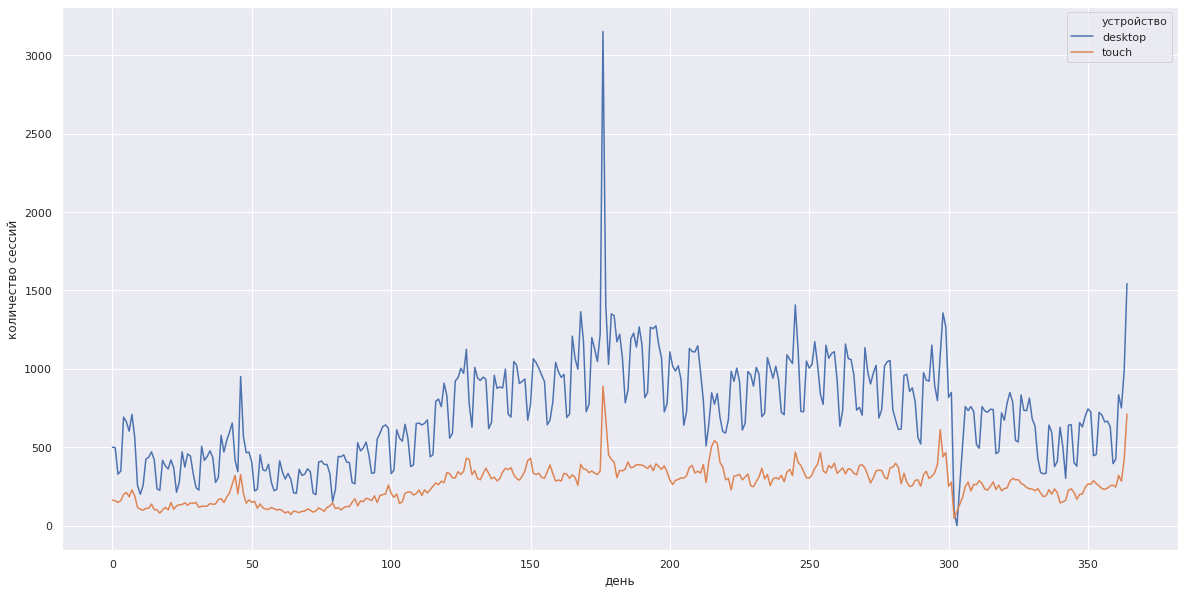

In [181]:
sns.set(rc={'figure.figsize':(20,10)})
ax = sns.lineplot(x='день', y='количество сессий', hue = 'устройство', data = session_per_day )

**ВЫВОД:** Количество сессий неравномерно с течением времени. В целом с настольных ПК (desktop) заходит больше пользователей. Частые пики и провалы на графике показывают разницу между рабочими и выходными днями.

### 2.3 Подсчет длительности одной сессии.

Получим длительность сессий в минутах. Исключим отрицательные значения. Свдем данные о средней длительности по неделям и устройствам, с которых осуществлялась сессия. Построим график.

In [182]:
session_time = visits [['device','end_ts','start_ts','start_ts_week']]

session_time = session_time [session_time['end_ts'] > session_time['start_ts']]

session_time['timedelta'] = (
    ((session_time['end_ts']  - session_time['start_ts'])/ np.timedelta64(1,'m'))
    .round().astype(int)
)

session_time = session_time.groupby(['device', 'start_ts_week'])['timedelta'].mean().reset_index()

session_time.head()

,device,start_ts_week,timedelta
0,desktop,0,12.062910
1,desktop,1,12.126158
2,desktop,2,11.725446
3,desktop,3,11.296925
4,desktop,4,12.369821


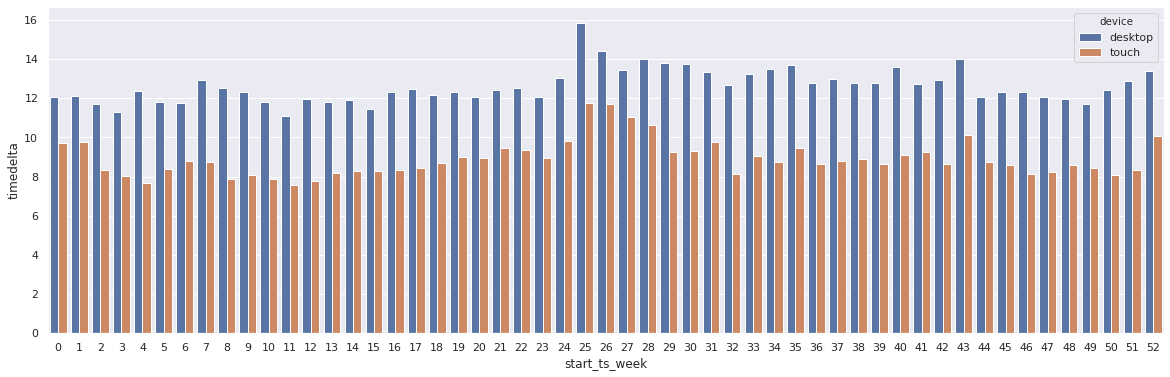

In [183]:
sns.set(rc={'figure.figsize':(20,6)})
ax = sns.barplot(x="start_ts_week", y="timedelta", data=session_time, ci=False, hue = 'device')

**ВЫВОД:** Длитальность сессий пользователей использующих ПК (desktop) больше чем пользователей использующих мобильные устройства (touch).
Средняя длительность сессий по времени (по неделям) показана на графике.

### 2.4 Подсчет возвращающихся пользователей. (Retention Rate)

Найдем коэфициент удержания Retention Rate за каждый последующий месяц после первого посещения.

Для начала найдем месяц первой сессии у каждого пользователя. 

In [184]:
first_activity_date = visits.groupby('uid')['start_ts'].min()

first_activity_date.name = 'first_activity_date'

user_activity = visits[['uid','start_ts_month', 'device']].join(first_activity_date,on='uid')

user_activity['first_activity_month'] = user_activity['first_activity_date'].astype('datetime64[M]')

In [185]:
user_activity.head(3)

,uid,start_ts_month,device,first_activity_date,first_activity_month
0,16879256277535980062,2017-12-01,touch,2017-12-20 17:20:00,2017-12-01
1,104060357244891740,2018-02-01,desktop,2018-02-19 16:53:00,2018-02-01
2,7459035603376831527,2017-07-01,touch,2017-07-01 01:54:00,2017-07-01


Найдем **"lifetime"** 

In [186]:
user_activity['lifetime'] = user_activity['start_ts_month'] - user_activity['first_activity_month']
user_activity['lifetime'] = user_activity['lifetime'] / np.timedelta64(1,'M')
user_activity['lifetime'] = user_activity['lifetime'].round().astype(int)

Сгруппируем пользователей по месяцу первой сессии. Это будут наши когорты.

In [187]:
cohorts = user_activity.groupby(['first_activity_month','lifetime']).agg({'uid':'nunique'}).reset_index()
cohorts.head(5)

,first_activity_month,lifetime,uid
0,2017-06-01,0,13259
1,2017-06-01,1,1043
2,2017-06-01,2,713
3,2017-06-01,3,814
4,2017-06-01,4,909


Найдём исходное количество пользователей в когорте. 

In [188]:
initial_users_count = cohorts[cohorts['lifetime'] == 0][['first_activity_month','uid']]
initial_users_count.columns = ['first_activity_month','cohort_users']

Объединим данные по когортам с исходным количеством пользователей в когорте

In [189]:
cohorts = cohorts.merge(initial_users_count,on='first_activity_month')

Рассчитаем Retention Rate.

In [190]:
cohorts['retention'] = cohorts['uid']/cohorts['cohort_users']

Построим сводную таблицу и создадим тепловую карту

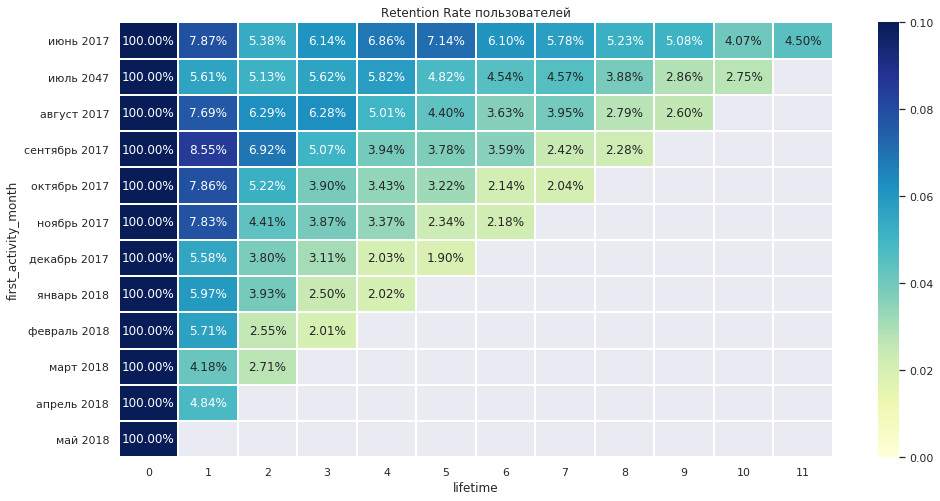

In [191]:
rr_pivot = cohorts.pivot_table(index='first_activity_month',columns='lifetime',values='retention',aggfunc='sum')

mounth = [ 'июнь 2017', 'июль 2047', 'август 2017', 'сентябрь 2017', 'октябрь 2017','ноябрь 2017', 'декабрь 2017', 
          'январь 2018', 'февраль 2018', 'март 2018', 'апрель 2018', 'май 2018']

plt.figure(figsize=(16, 8))
plt.title('Retention Rate пользователей')

sns.heatmap(rr_pivot, vmin=0, vmax=0.1, annot=True, fmt='.2%', linewidths=1, cmap="YlGnBu", yticklabels=mounth)

**ВЫВОД:** Первое что хочется заметить так это то что процент возрата пользователей не убывает плавно от месяца к месяцу, т.е. в некоторых когортах наблюдается увеличение активности пользователей по отношению к предыдущему месяцу.  Пользователи с первой сессией в июне 2017, самые "стойкие", и чаще других повторно используют сервис. 

Найдем общий процент "возвращенцев" (пользователей имеющих два и более визитов) от общего количества пользователей.

In [192]:
count_of_users_visit = visits.groupby('uid')['start_ts'].count()

procent_2 = (len(count_of_users_visit [count_of_users_visit >= 2])
        / len(visits['uid'].unique())
              *100)
procent_3 = (len(count_of_users_visit [count_of_users_visit >= 3])
        / len(visits['uid'].unique())
              *100)
procent_4 = (len(count_of_users_visit [count_of_users_visit >= 4])
        / len(visits['uid'].unique())
              *100)

print(procent_2, 'Процент пользователей совершивших два визита')
print(procent_3, 'Процент пользователей совершивших три визита')
print(procent_4, 'Процент пользователей совершивших четыре визита')

22.84622363248294 Процент пользователей совершивших два визита
9.292235141495997 Процент пользователей совершивших три визита
4.828876841288694 Процент пользователей совершивших четыре визита


### 2.5 Первая покупка (Когда люди начинают покупать)

Сгруппируем таблицу визитов по первому дню визита, а таблицу покупок по дню покупки.

In [193]:
first_visit = visits.groupby(['uid','device']).agg({'start_ts_day': 'min'}).reset_index() 

orders['buy_ts_day'] = orders['buy_ts'].astype('datetime64[D]')

first_buy = orders.groupby('uid').agg({'buy_ts_day': 'min'}).reset_index() 

Обьеденим две таблицы и найдем дельту времени в днях, между днем первой покупки и днем первого визита. Удалим отрицательные значения.

In [194]:
visit_buy_time_table = first_buy.merge(first_visit, how='left', on = 'uid')

visit_buy_time_table['delta_time'] = (
    ((visit_buy_time_table['buy_ts_day'] - visit_buy_time_table['start_ts_day'])/ np.timedelta64(1,'D'))
    .round().astype(int)
)
visit_buy_time_table = visit_buy_time_table[visit_buy_time_table['delta_time']>0]
visit_buy_time_table.head()

,uid,buy_ts_day,device,start_ts_day,delta_time
0,313578113262317,2018-01-03,desktop,2017-09-18,107
3,2464366381792757,2018-01-28,desktop,2018-01-27,1
6,3605148382144603,2017-09-21,desktop,2017-08-15,37
10,5081614443770358,2017-11-13,desktop,2017-10-20,24
14,9681021228476518,2017-12-08,desktop,2017-12-07,1


Построим графики с учетом разных используемых устройств пользователями.

Text(0, 0.5, 'кол-во пользователей совершивших покупку')

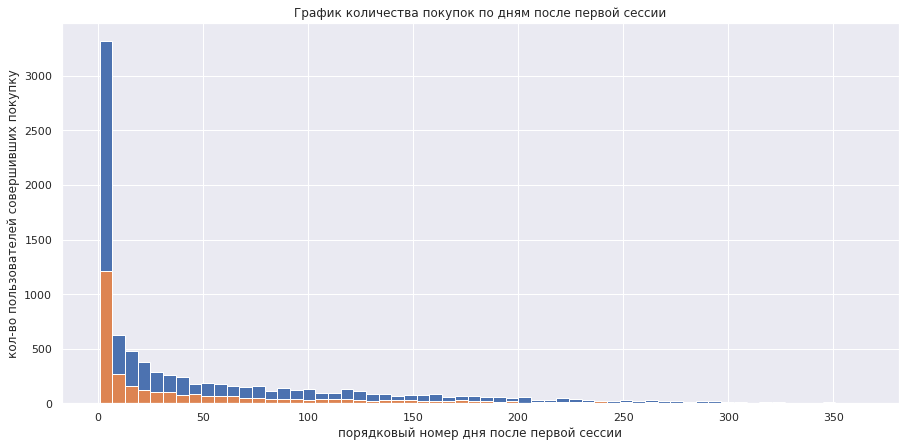

In [195]:
visit_buy_time_table[visit_buy_time_table['device'] == 'desktop']['delta_time'].hist( figsize = (15, 7), bins = 60)
visit_buy_time_table[visit_buy_time_table['device'] == 'touch']['delta_time'].hist( figsize = (15, 7), bins = 60)

plt.title('График количества покупок по дням после первой сессии')
plt.xlabel('порядковый номер дня после первой сессии')
plt.ylabel('кол-во пользователей совершивших покупку')

**ВЫВОД:** Похоже что подавляющее большинство пользователей со всех устройств, делают покупки уже в первый день визита.

### 2.6 Подсчет количества покупок за период

Возьмем за период - одну неделю. Сгруппируем данные о покупках по номеру недели. Также добавим информацию об устройствах пользователей из таблицы visits

In [196]:
users_device = visits[['device','uid']].drop_duplicates('uid')

orders['week'] = (((orders['buy_ts'] - orders['buy_ts'].min())
                            /np.timedelta64(1,'W'))
                           .round()
                           .astype('int'))

orders_week_device = orders[['week','revenue','uid']].merge(users_device,  how='left')
  
    
orders_count_week = orders_week_device.groupby(['week','device'])['revenue'].count().reset_index()

In [197]:
orders_count_week.head(5)

,week,device,revenue
0,0,desktop,239
1,0,touch,47
2,1,desktop,823
3,1,touch,149
4,2,desktop,291


Построим график количества продаж, в зависимости от номера недели и используемому устройству пользователями.

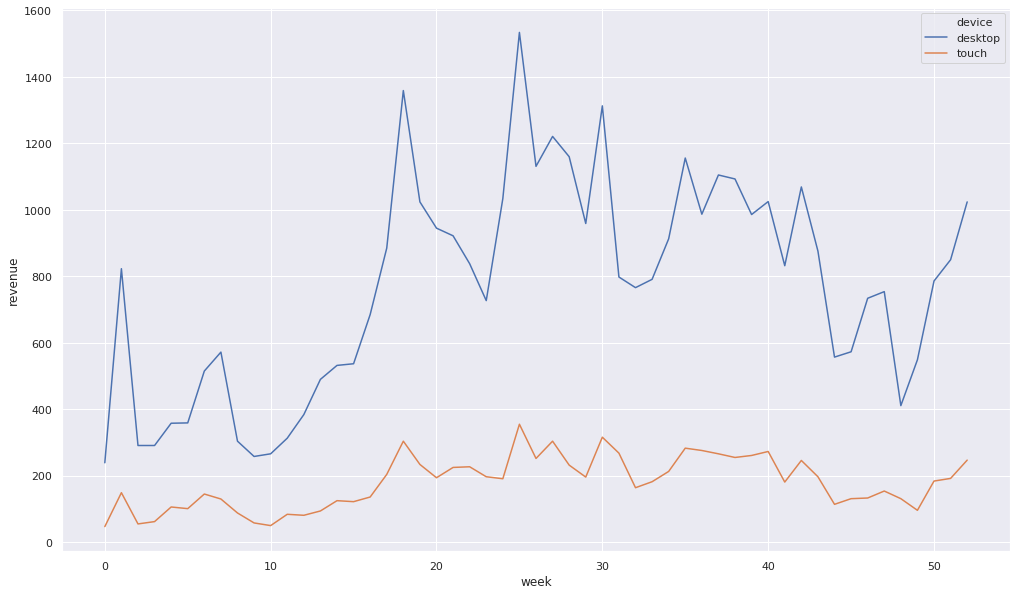

In [198]:
sns.set(rc={'figure.figsize':(17,10)})

ax = sns.lineplot(x='week', y='revenue', hue = 'device', data = orders_count_week, ci=None)

**ВЫВОД:** Количество покупок сильно меняется во времени. Количество покупок по неделям можно увидеть на графике.

На количество покупок в конкретной неделе влияют два фактора  - приход в разные недели разного количества новых пользователей  и активность небольшой части старых пользователей.  

Ясно одно - с ПК (desktop) покупают больше чем с мобильных устройств (touch) т.к. опять же пользователей с ПК больше.

### 2.7 Подсчет среднего чека

Разобьем покупателей на месячные когорты. Подсчитаем средний чек когорт с учетом месяца и используемому устройству. Построим график.

In [199]:
first_order_date = orders.groupby('uid')['buy_ts'].min()
first_order_date.name = 'first_order_date'

orders_month = orders.join(first_order_date,on='uid')

orders_month['first_order_month'] = orders_month['first_order_date'].astype('datetime64[M]')

orders_month['month'] = (((orders_month['buy_ts'] - orders_month['buy_ts'].min())
                            /np.timedelta64(1,'M'))
                           .round()
                           .astype('int'))


visits_user_device = visits[['uid', 'device']].drop_duplicates()

orders_month_device = orders_month.merge(visits_user_device, how = 'left', on = 'uid')

In [200]:
orders_month.head()

,buy_ts,revenue,uid,buy_ts_day,week,first_order_date,first_order_month,month
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,0,2017-06-01 00:10:00,2017-06-01,0
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,0,2017-06-01 00:25:00,2017-06-01,0
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01,0,2017-06-01 00:27:00,2017-06-01,0
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01,0,2017-06-01 00:29:00,2017-06-01,0
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01,0,2017-06-01 07:58:00,2017-06-01,0


Таблица показывающая средний чек по когортам для пользователей использующих ПК (desktop)

In [201]:
orders_month_device[orders_month_device['device'] == 'desktop'].pivot_table(index='first_order_month',
    columns='month',
    values='revenue',
    aggfunc='mean')

month,0,1,2,3,4,5,6,7,8,9,10,11,12
first_order_month,,,,,,,,,,,,,
2017-06-01,3.70442,5.086754,4.224545,7.419029,8.103096,5.804515,7.629038,5.898535,6.527684,7.262537,4.839658,15.472308,4.856909
2017-07-01,NaN,5.072540,5.745321,6.916022,10.961417,4.470484,4.233855,3.669677,4.610702,9.153333,2.862750,10.442727,5.750625
2017-08-01,NaN,NaN,4.483693,4.926308,7.618571,7.262418,7.478684,6.527581,6.556071,7.424138,6.629808,7.300339,8.105625
2017-09-01,NaN,NaN,NaN,4.234347,6.338246,12.089398,42.058071,39.093563,18.320971,15.654667,10.468082,10.556327,8.291622
2017-10-01,NaN,NaN,NaN,NaN,4.017303,5.225577,7.346093,5.154769,6.110702,4.993504,4.974675,4.587857,3.681667
2017-11-01,NaN,NaN,NaN,NaN,NaN,4.441829,4.180784,4.231148,5.286111,6.798353,3.464946,4.434500,4.467463
2017-12-01,NaN,NaN,NaN,NaN,NaN,NaN,3.767621,4.638975,7.767143,21.689000,31.897117,29.173678,2.782963
2018-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.609799,3.904917,4.557152,8.150792,4.670290,2.735854
2018-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.812338,3.888325,3.444821,3.485079,3.939545


Таблица показывающая средний чек по когортам для пользователей использующих ПК (device)

In [202]:
orders_month_device[orders_month_device['device'] == 'touch'].pivot_table(index='first_order_month',
    columns='month',
    values='revenue',
    aggfunc='mean')

month,0,1,2,3,4,5,6,7,8,9,10,11,12
first_order_month,,,,,,,,,,,,,
2017-06-01,2.748624,5.199574,3.981714,5.126818,14.068689,6.301000,5.109884,6.295660,3.707000,5.395581,5.943514,9.416667,12.877500
2017-07-01,NaN,4.495799,6.666935,12.398750,17.845278,4.852069,5.202759,4.432105,3.010435,9.622083,2.436786,16.689167,4.234615
2017-08-01,NaN,NaN,4.690942,4.656301,7.660909,3.413333,7.926923,7.664615,4.788421,9.566923,1.827500,13.118750,11.078750
2017-09-01,NaN,NaN,NaN,3.875121,6.630590,11.558980,10.088312,7.670870,17.983846,25.052564,4.546667,13.764167,6.709231
2017-10-01,NaN,NaN,NaN,NaN,3.863089,5.363836,7.765658,3.000444,4.012105,6.283200,2.927333,2.094375,2.663182
2017-11-01,NaN,NaN,NaN,NaN,NaN,4.916644,5.036005,4.826038,5.261071,11.432963,3.457895,3.130000,1.251667
2017-12-01,NaN,NaN,NaN,NaN,NaN,NaN,2.901535,3.910993,3.303696,3.663235,2.391600,2.264118,1.645000
2018-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.990520,3.667614,4.925385,11.608235,9.808333,3.030000
2018-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.343056,3.911595,3.211429,2.138000,2.120714


Построим общий график показывающий средний чек когорт.

In [203]:
def convert_date (date):
    return date.strftime("%d %B, %Y")

orders_month_device['date_str'] = orders_month_device['first_order_month'].apply(convert_date)

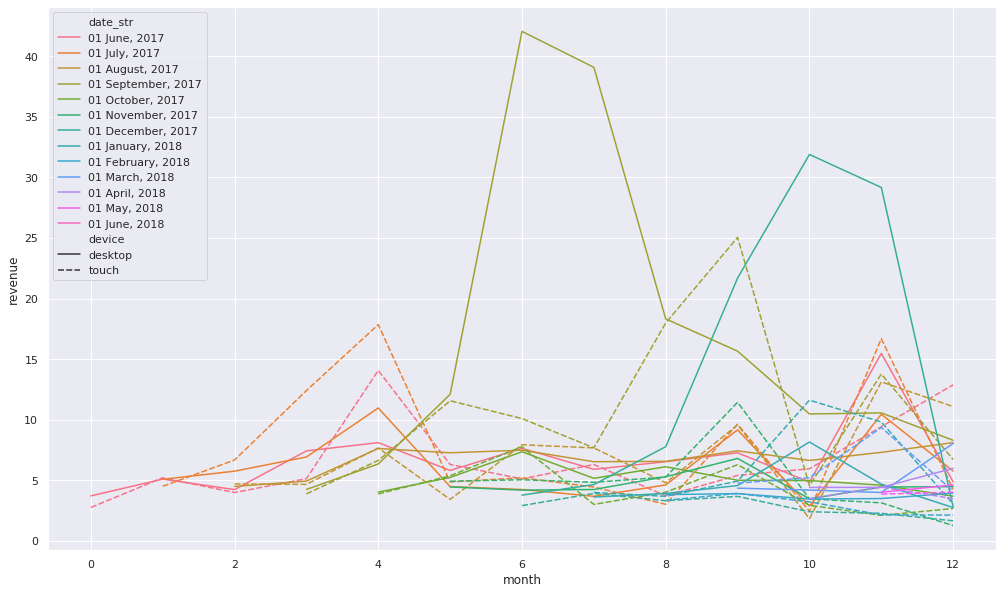

In [204]:
sns.set(rc={'figure.figsize':(17,10)})

ax = sns.lineplot(x='month', y='revenue', hue = 'date_str', style = 'device', data = orders_month_device, ci=None)

График показывающий средний чек по неделям, без привязки к когортам.

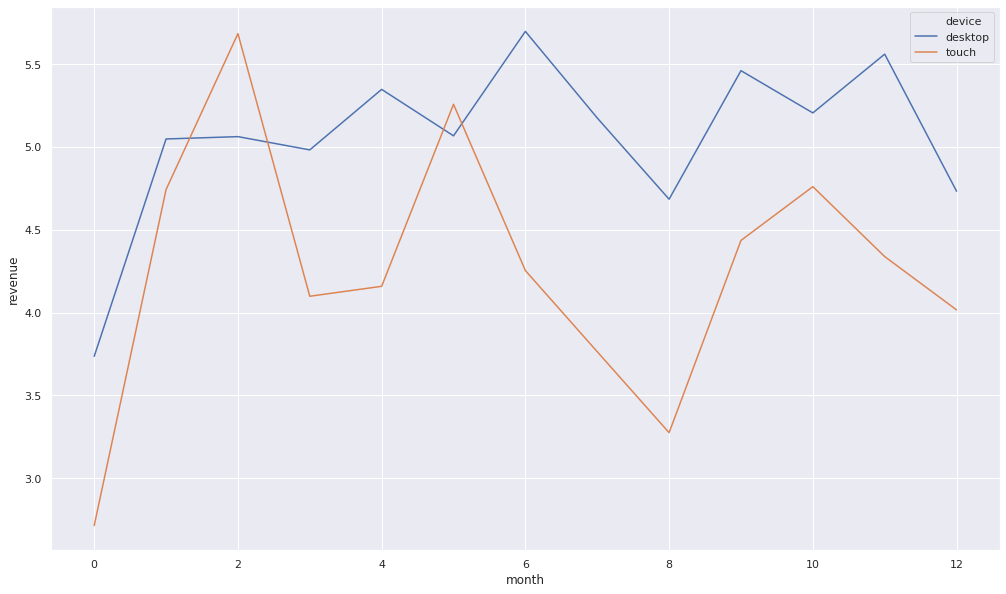

In [205]:
users_device = visits[['device','uid']].drop_duplicates('uid')

orders['month'] = (((orders['buy_ts'] - orders['buy_ts'].min())
                            /np.timedelta64(1,'M'))
                           .round()
                           .astype('int'))

orders_month_device = orders[['month','revenue','uid']].merge(users_device,  how='left')

orders_mean_month = orders_month_device.groupby(['month','device'])['revenue'].mean().reset_index()

sns.set(rc={'figure.figsize':(17,10)})

ax = sns.lineplot(x='month', y='revenue', hue = 'device', data = orders_mean_month, ci=None)

**ВЫВОД:** 

Если смотреть на средний чек по когортам то он сильно "скачет"(от 2 до 42) в зависимости от времени, что видно в таблицах. Ввиду того что **Retention Rate** очень мал, среднее значение может сильно "скакать" ввиду малого количества вернувшихся покупателей когорты. 

Если смотреть в целом, без учета когорт, то средний чек пользователей ПК (desktop) и мобильных устройств (touch) по времени, скачет не так сильно.(от 3.3 до 5.8)

Средний чек пользователей ПК и мобильных устройств за весь рассматриваемый период примерно одинаков, что показывают расчеты ниже.

In [206]:
orders_mean_desktop = orders_month_device[orders_month_device['device'] == 'desktop']['revenue'].median().round(1)
orders_mean_touch = orders_month_device[orders_month_device['device'] == 'touch']['revenue'].median().round(1)

print('Средний чек пользователей ПК: ', orders_mean_desktop)
print('Средний чек пользователей моб.устройств: ', orders_mean_touch)

Средний чек пользователей ПК:  2.7
Средний чек пользователей моб.устройств:  2.4


### 2.8 Подсчет LTV

Найдем месяц первой покупки каждого пользователя

In [208]:
first_order = orders.groupby('uid')['month'].min().reset_index()
first_order.columns = ['uid', 'first_order_month']
first_order.head(3)

,uid,first_order_month
0,313578113262317,7
1,1575281904278712,0
2,2429014661409475,4


Найдем суммарный доход от каждого уникального пользователя

In [209]:
orders_new = orders.groupby('uid')['revenue'].sum().reset_index()

Добавим в таблицу с суммарными доходами от пользователя, столбец с месяцем первой покупки.

In [210]:
orders_new = orders_new.merge(first_order)
orders_new.head(3)

,uid,revenue,first_order_month
0,313578113262317,0.55,7
1,1575281904278712,3.05,0
2,2429014661409475,73.33,4


Найдем для каждго пользователя источник откуда он пришел.

In [211]:
users_sourse = visits[['uid','source_id']].drop_duplicates('uid')
users_sourse.head(3)

,uid,source_id
0,16879256277535980062,4
1,104060357244891740,2
2,7459035603376831527,5


Добавим столбец с источником откуда пришел пользователь в таблицу с суммарными доходами от пользователя

In [212]:
orders_new = orders_new.merge(users_sourse)
orders_new.head(3)

,uid,revenue,first_order_month,source_id
0,313578113262317,0.55,7,2
1,1575281904278712,3.05,0,10
2,2429014661409475,73.33,4,3


Сгруппируем таблицу по источнику и месяцу первой покупки. Найдем количество покупателей каждой когорты и общую сумму дохода от них. 

In [213]:
orders_group = orders_new.groupby(['source_id','first_order_month']).agg({'revenue': 'sum', 'uid': 'count'}).reset_index()
orders_group.columns = ['source_id', 'first_order_month', 'revenue', 'n_byers']
orders_group.head(3)

,source_id,first_order_month,revenue,n_byers
0,1,0,5802.04,136
1,1,1,3839.41,163
2,1,2,1501.02,177


Посчитаем средний LTV пользователей по когортам

In [214]:
orders_group['ltv'] = orders_group['revenue'] / orders_group['n_byers']

In [215]:
orders_group.head(3)

,source_id,first_order_month,revenue,n_byers,ltv
0,1,0,5802.04,136,42.662059
1,1,1,3839.41,163,23.554663
2,1,2,1501.02,177,8.480339


Выведем сводную таблицу где покажем LTV каждой когорты 

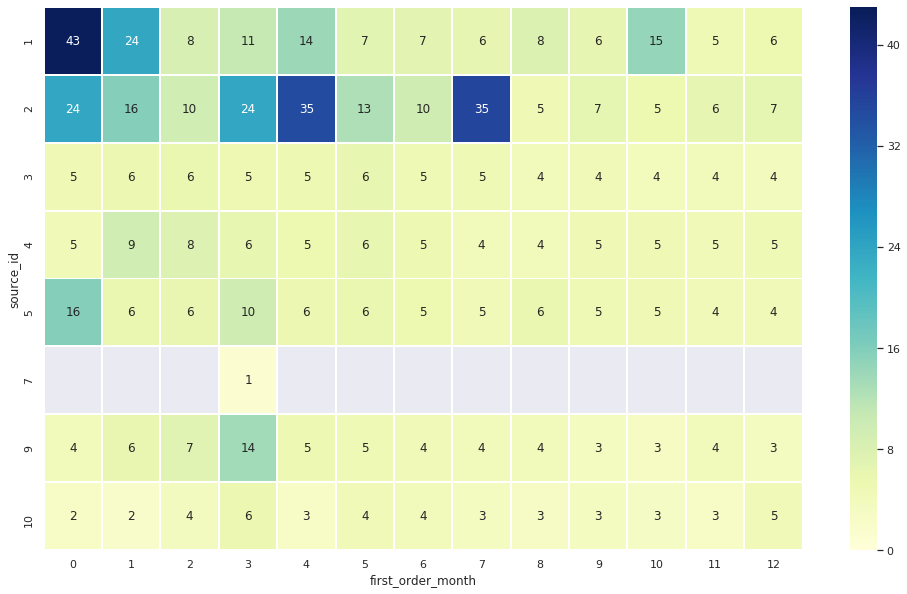

In [216]:
output = orders_group.pivot_table(
        index=('source_id'), 
        columns='first_order_month', 
        values='ltv', 
        aggfunc='mean').round(2)

sns.heatmap(output, vmin=0, vmax=43, annot=True, fmt='.0f', linewidths=1, cmap="YlGnBu")

**ВЫВОД:** LTV покупателей из 1-ого источника, зарегистрированных в первом месяце самый большой. Хорошие показатели LTV у пользователей пришедших из второго источника в первые 8 месяцев.

### 2.9 Подсчет расходов. (всего / на каждый источник / по времени)

Добавим в таблицу расходов, месячный период когда была потрачена сумма.

In [217]:
costs['month'] = (((costs['dt'] - costs['dt'].min())
                            /np.timedelta64(1,'M'))
                           .round()
                           .astype('int'))

In [218]:
costs_group = costs.groupby(['source_id','month'])['costs'].sum().reset_index()
costs_group.columns = ['source_id','first_order_month','costs']
costs_group.head(3)

,source_id,first_order_month,costs
0,1,0,710.40
1,1,1,980.90
2,1,2,939.37


Сгруппируем таблицы расходов и покупок.

In [219]:
result = orders_group.merge(costs_group, how= 'left')
result.head(3)

,source_id,first_order_month,revenue,n_byers,ltv,costs
0,1,0,5802.04,136,42.662059,710.40
1,1,1,3839.41,163,23.554663,980.90
2,1,2,1501.02,177,8.480339,939.37


Для наглядности построим график.

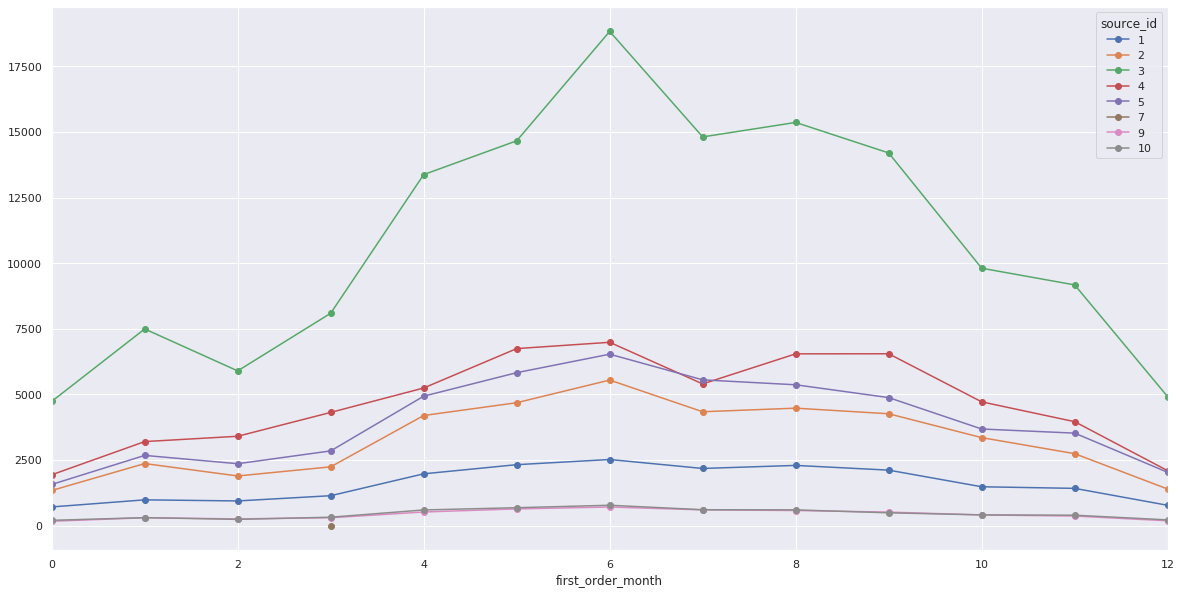

In [220]:
costs_report = result.pivot_table(index = 'first_order_month', columns = 'source_id', values = 'costs', aggfunc = 'sum' )
costs_report.plot(style='o-', grid=True, figsize=(20, 10))

Выведем сводную таблицу с накопленными суммарными расходами от месяца к месяцу.

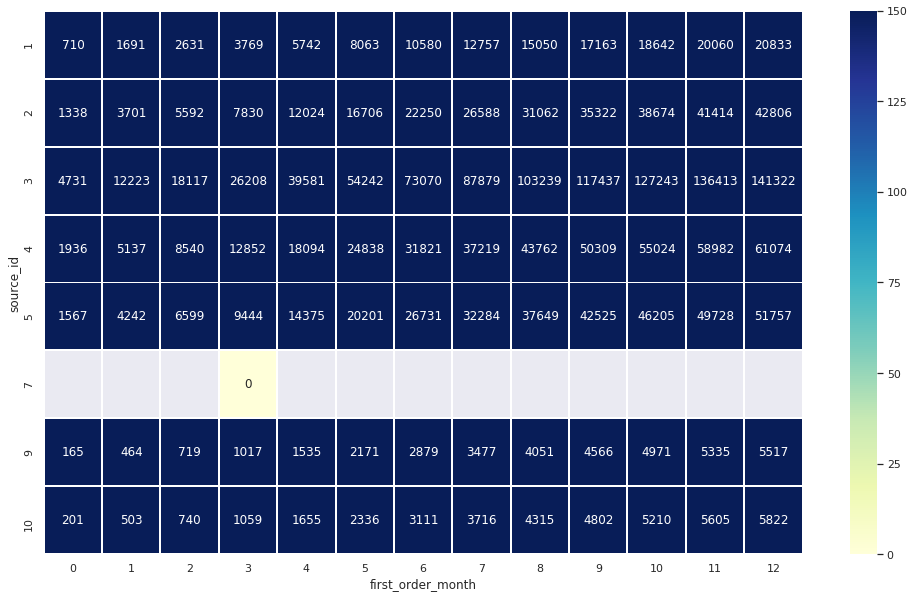

In [221]:
costs_report = result.pivot_table(index = 'source_id', columns = 'first_order_month', values = 'costs', aggfunc = 'sum')
costs_report = costs_report.cumsum(axis=1).round(2)
sns.heatmap(costs_report, vmin=0, vmax=150, annot=True, fmt='.0f', linewidths=1, cmap="YlGnBu")

**ВЫВОД:** Из таблицы видно что суммарно на конец 11 месяца на источник трафика №3 потрачено больше всего средств. Также по графику видно что пик затрат приходится на 7 месяц.

### 2.10 Расчет CAC

Посчитаем расходы на одного покупателя (САС)

In [222]:
result.head()

,source_id,first_order_month,revenue,n_byers,ltv,costs
0,1,0,5802.04,136,42.662059,710.40
1,1,1,3839.41,163,23.554663,980.90
2,1,2,1501.02,177,8.480339,939.37
3,1,3,2080.18,193,10.778135,1138.70
4,1,4,5481.43,391,14.019003,1972.45


In [223]:
result['cac'] = result['costs'] / result['n_byers']
result.head(3)

,source_id,first_order_month,revenue,n_byers,ltv,costs,cac
0,1,0,5802.04,136,42.662059,710.40,5.223529
1,1,1,3839.41,163,23.554663,980.90,6.017791
2,1,2,1501.02,177,8.480339,939.37,5.307175


Выведем среднюю сумму расходов на привлечение покупателя на конец каждого месяца с учетом источника откуда пришел покупатель.

In [224]:
output = result.pivot_table(
        index=('source_id'), 
        columns='first_order_month', 
        values='cac', 
        aggfunc='mean').round(2)

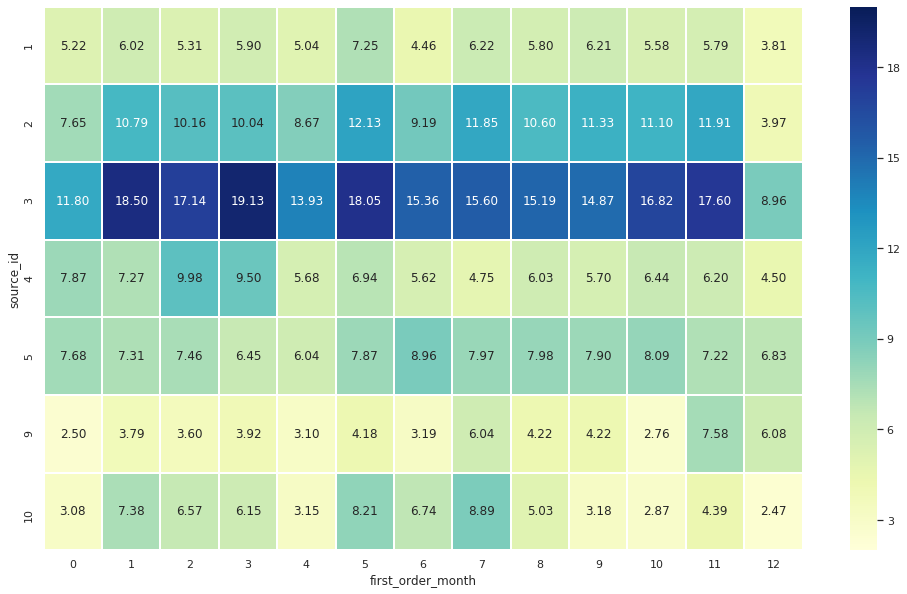

In [225]:
sns.heatmap(output, vmin=2, vmax=20, annot=True, fmt='.2f', linewidths=1, cmap="YlGnBu")

**ВЫВОД** Самые большие расходы в каждом отдельном месяце приходятся на источник №3.

### 2.11 Расчет ROMI

In [226]:
result['romi'] = result['ltv'] / result['cac']

Выведем таблицу с ROMI покупателя по месяцу регистрации его регистрации и  с учетом источника откуда пришел покупатель.

In [227]:
output = result.pivot_table(
        index=('source_id'), 
        columns='first_order_month', 
        values='romi', 
        aggfunc='mean').round(4)
#output = output.cumsum(axis=1).round(2)

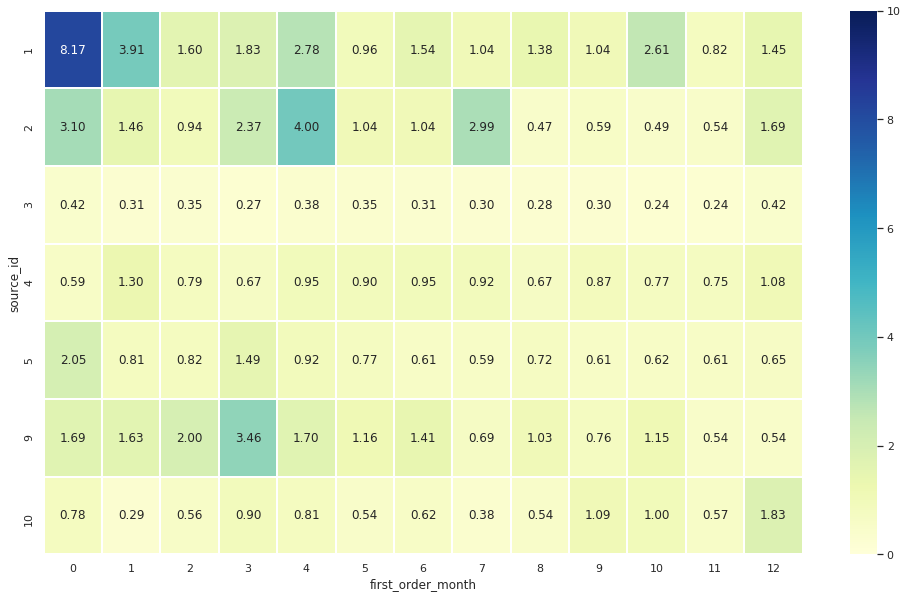

In [228]:
sns.heatmap(output, vmin=0, vmax=10, annot=True, fmt='.2f', linewidths=1, cmap="YlGnBu")

**ВЫВОД:** Покупатели зарегистрированные в первом месяце, пришедшие из первого источника показывают самый большой ROMI. Самый низкий ROMI среди покупателей пришедших из третьего источника, не зависимо от месяца регистрации. 

# 3. Выводы

В данном проекте проанализировали данные Яндекс метрики. Расчитали различные параметры.

Retention Rate очень низкий по времени да и еще уменьшается у каждой новой когорты. Т.е. каждый новый привлеченный пользователь возвращается за повторной покупкой все реже. Надо смотреть почему так.

Затраты на рекламные источники тоже стоит пересмотреть. Например самый "неэфективный" оказался источник №3 на который затратили больше всего ресурсов. Конечно этот источник принес больше всех пользователей но в пересчете на одного пользователя, затраты больше чем у других источников. Самые результативные источники это №1,№2,№9 

В лидерах по использованию - ПК (desktop), с мобильных устройств заходят меньше пользователей, сессии короче.